In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
tf.config.list_logical_devices('GPU')

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

# 1. Preparing the data

In [4]:
train_df = pd.read_csv('./dataset/train.csv', encoding='ISO-8859-1')
test_df = pd.read_csv('./dataset/test.csv', encoding='ISO-8859-1')

In [5]:
train_df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


<Axes: xlabel='sentiment'>

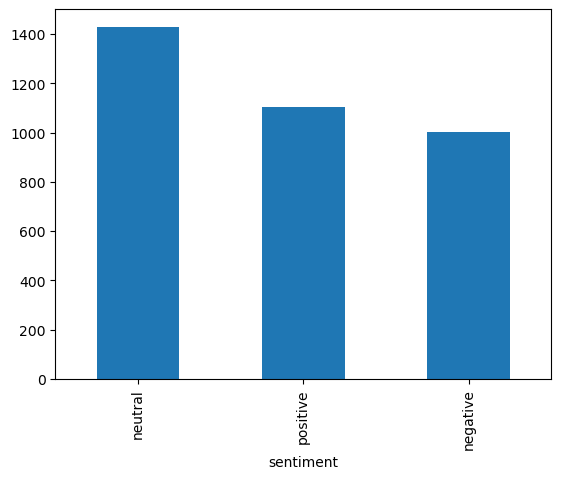

In [6]:
test_df.sentiment.value_counts().plot(kind='bar')

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km²)   27481 non-null  float64
 9   Density (P/Km²)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB


In [7]:
train_df = train_df[['text', 'sentiment']]
test_df = test_df[['text', 'sentiment']]


train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [8]:
train_texts = train_df.text.astype(str).values
test_texts = test_df.text.astype(str).values

CLASSES = train_df.sentiment.unique()
class_to_idx = {name: index for index, name in enumerate(CLASSES)}

train_labels = train_df.sentiment.map(class_to_idx).values
test_labels = test_df.sentiment.map(class_to_idx).values

In [9]:
vectorizer = tf.keras.layers.TextVectorization(max_tokens=10000,output_mode='int', output_sequence_length=128)
vectorizer.adapt(train_texts)

In [10]:
train_ds = tf.data.Dataset.from_tensor_slices((train_texts, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_texts, test_labels))

In [11]:
train_ds = train_ds.shuffle(1000).batch(128).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(128).prefetch(tf.data.AUTOTUNE)


# 2. Model building using Sequential API

In [12]:
# from tensorflow.keras import Sequential

# model = Sequential([
#     vectorizer,

#     tf.keras.layers.Embedding(10000, 128),
#     tf.keras.layers.LSTM(64, return_sequences=True),
#     tf.keras.layers.GlobalMaxPooling1D(),
    
#     tf.keras.layers.Dense(64),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Activation('relu'),    
    
#     tf.keras.layers.Dense(32),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Activation('relu'),

#     tf.keras.layers.Dense(len(CLASSES)),
#     tf.keras.layers.Activation('softmax')

# ])

In [ ]:
from tensorflow.keras import Sequential

model = Sequential([
    vectorizer,

    tf.keras.layers.Embedding(10000, 16),
    tf.keras.layers.Conv1D(filters=16, kernel_size=5),
    tf.keras.layers.GlobalMaxPooling1D(),
    
    tf.keras.layers.Dense(8),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),    

    tf.keras.layers.Dense(len(CLASSES)),
    tf.keras.layers.Activation('softmax')

])

In [42]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 128)              0         
 torization)                                                     
                                                                 
 embedding_7 (Embedding)     (None, 128, 16)           160000    
                                                                 
 conv1d_12 (Conv1D)          (None, 124, 16)           1296      
                                                                 
 global_max_pooling1d_3 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_12 (Dense)            (None, 8)                 136       
                                                                 
 batch_normalization_6 (Batc  (None, 8)               

# 3. Model Training

In [43]:
import datetime as dt

lr_scheduler = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.1, decay_steps=1000)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

log_dir = './logs/' + dt.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True, embeddings_freq=1)
earlystopping_cb = tf.keras.callbacks.EarlyStopping(patience=2, verbose=1, monitor='val_accuracy')
callbacks = [tensorboard_cb, earlystopping_cb]

In [44]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [45]:
model.fit(train_ds, validation_data=test_ds, callbacks=callbacks, epochs=30)

Epoch 1/30
215/215 [==============================] - 5s 18ms/step - loss: 0.9164 - accuracy: 0.5458 - val_loss: 0.8295 - val_accuracy: 0.6154
Epoch 2/30
215/215 [==============================] - 3s 16ms/step - loss: 0.6501 - accuracy: 0.7260 - val_loss: 0.7986 - val_accuracy: 0.6808
Epoch 3/30
215/215 [==============================] - 3s 16ms/step - loss: 0.4928 - accuracy: 0.8039 - val_loss: 0.9187 - val_accuracy: 0.6675
Epoch 4/30
215/215 [==============================] - 3s 16ms/step - loss: 0.3493 - accuracy: 0.8689 - val_loss: 0.9240 - val_accuracy: 0.6969
Epoch 5/30
215/215 [==============================] - 3s 16ms/step - loss: 0.2645 - accuracy: 0.9077 - val_loss: 0.9003 - val_accuracy: 0.6933
Epoch 6/30
215/215 [==============================] - 3s 16ms/step - loss: 0.2556 - accuracy: 0.9114 - val_loss: 0.8994 - val_accuracy: 0.6933
Epoch 6: early stopping


# 4. Inference

In [48]:
text = test_texts[802]
index = model.predict([text]).argmax()

print(text)
print(f"It is : {CLASSES[index]}")

1/1 [==============================] - 0s 75ms/step
Oh..Summer begins..yay..  The fighting, Crying and stress has started with the kids..It`s only been 3 hrs since they got out.
It is : negative


# 5. Model Saving

In [24]:
model.save('./best_model')

INFO:tensorflow:Assets written to: ./best_model\assets


INFO:tensorflow:Assets written to: ./best_model\assets


In [25]:
%load_ext tensorboard
%tensorboard --logdir=logs